---
layout: post
title:  "Red sources around the z=7.54 quasar ULAS J1342+0928"
date:   "2019-11-15 15:47:08 +0100"
categories: research alma charge

---

# Red sources around the z=7.54 quasar ULAS J1342+0928

I was testing algorithms for automatic processing of *Spitzer* IRAC data that overlaps with HST pointings from the CHArGE / GOLF project and came across some interesting sources in the field around a known quasar at z=7.54 ([Banados et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019ApJ...881L..23B/abstract)).

The automatically-reduced CHArGE images of the field can be found at [https://s3.amazonaws.com/grizli-v1/Pipeline/j134208p0929/Prep/j134208p0929.summary.html](https://s3.amazonaws.com/grizli-v1/Pipeline/j134208p0929/Prep/j134208p0929.summary.html).

In [75]:
import os
import matplotlib.pyplot as plt
import numpy as np

import boto3

import astropy.wcs as pywcs
import astropy.io.fits as pyfits

from grizli.pipeline import photoz, auto_script
from grizli import utils
utils.set_warnings()

In [76]:
root = 'j134208p0929'

## Fetch files from CHArGE AWS

All of the HST products are produced automatically as for the many other archival survey fields.  Here, I've also included the generated IRAC images and models for them that have been generated by convolving sources detected in the HST catalog (`{root}_phot.fits`) with a kernel to match the IRAC CH1 and Ch2 PSFs.  The resulting IRAC model photometry is similar to that produced by codes such as "MOPHONGO" (Labbe et al.) and "T-PHOT" (Merlin et al.).  Details of the IRAC processing TBD.

In [77]:
## Mosaics and photometry file that includes IRAC ch1 + ch2
s3 = boto3.resource('s3')
bkt = s3.Bucket('grizli-v1')

# Catalog with IRAC model photometry.  
files = ['Pipeline/{0}/IRAC/{0}irac_phot.fits'.format(root)]

# ALMA fluxes of serendipitous source shown below
files += ['Pipeline/{0}/IRAC/alma_serendip_j134208.65p092844.10.fits'.format(root)]

# Automatically produced HST mosaics
files += ['Pipeline/{0}/Prep/{0}-f125w_drz_sci.fits.gz'.format(root), 
          'Pipeline/{0}/Prep/{0}-f105w_drz_sci.fits.gz'.format(root),
          'Pipeline/{0}/Prep/{0}-f814w_drc_sci.fits.gz'.format(root)]

# Automatic IRAC mosaics with new code
files += ['Pipeline/{0}/IRAC/{0}-ch1_drz_sci.fits'.format(root),
          'Pipeline/{0}/IRAC/{0}-ch1_model.fits'.format(root),
          'Pipeline/{0}/IRAC/{0}-ch2_drz_sci.fits'.format(root),
          'Pipeline/{0}/IRAC/{0}-ch2_model.fits'.format(root)]

for file in files:
    if not os.path.exists(os.path.basename(file.strip('.gz'))):
        print('Fetch {0}{1}'.format(s3_path, file))
        bkt.download_file(file, os.path.basename(file),
                      ExtraArgs={"RequestPayer": "requester"})    
    
        if file.endswith('.gz'):
            os.system('gunzip {0}'.format(file))
    else:
        print('Found {0}'.format(file))

Found Pipeline/j134208p0929/IRAC/j134208p0929irac_phot.fits
Found Pipeline/j134208p0929/IRAC/alma_serendip_j134208.65p092844.10.fits
Found Pipeline/j134208p0929/Prep/j134208p0929-f125w_drz_sci.fits.gz
Found Pipeline/j134208p0929/Prep/j134208p0929-f105w_drz_sci.fits.gz
Found Pipeline/j134208p0929/Prep/j134208p0929-f814w_drc_sci.fits.gz
Found Pipeline/j134208p0929/IRAC/j134208p0929-ch1_drz_sci.fits
Found Pipeline/j134208p0929/IRAC/j134208p0929-ch1_model.fits
Found Pipeline/j134208p0929/IRAC/j134208p0929-ch2_drz_sci.fits
Found Pipeline/j134208p0929/IRAC/j134208p0929-ch2_model.fits


## Photometric redshifts

The `grizli` pipeline includes a wrapper around [`eazy-py`](https://github.com/gbrammer/eazy-py) that knows how to read the auto-generated photometric catalogs.  The example here includes additional IRAC coverage.

In [78]:
# Run photo-zs with eazy-py
total_flux = 'flux_auto'
object_only=False
_res = photoz.eazy_photoz(root+'irac', object_only=object_only, 
                          apply_prior=False, beta_prior=True, 
                          aper_ix=1, force=True, 
                          get_external_photometry=False, 
                          compute_residuals=False, 
                          total_flux=total_flux)

self, cat, zout = _res

Apply catalog corrections
Compute aperture corrections: i=0, D=0.36" aperture
Compute aperture corrections: i=1, D=0.50" aperture
Compute aperture corrections: i=2, D=0.70" aperture
Compute aperture corrections: i=3, D=1.00" aperture
Compute aperture corrections: i=4, D=1.20" aperture
Compute aperture corrections: i=5, D=1.50" aperture
Compute aperture corrections: i=6, D=3.00" aperture
Write j134208p0929irac_phot_apcorr.fits
Read default param file: /Users/gbrammer/miniconda3/envs/grizli-dev/lib/python3.6/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: j134208p0929irac_phot_apcorr.fits
f105w_tot_1 f105w_etot_1 (202): hst/wfc3/IR/f105w.dat
f125w_tot_1 f125w_etot_1 (203): hst/wfc3/IR/f125w.dat
f814w_tot_1 f814w_etot_1 (239): hst/ACS_update_sep07/wfc_f814w_t81.dat
irac_ch1_flux irac_ch1_err ( 18): IRAC/irac_tr1_2004-08-09.dat
irac_ch2_flux irac_ch2_err ( 19): IRAC/irac_tr2_2004-08-09.dat
Read PRIOR_FILE:  templates/prior_F160W_TAO.dat
Process template tweak_fsps_QSF_12_v3_

/Users/gbrammer/miniconda3/envs/grizli-dev/lib/python3.6/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


## Select high-z sources

There is a pair of sources with photometric redshifts similar to that of the quasar. 

In [79]:
# Select high-z sources & show SEDs 
jmag = 23.9-2.5*np.log10(self.cat['f125w_tot_1'])
sel = (self.cat['f814w_etot_1'] > 0) & (self.zbest > 7)
so = np.argsort(jmag[sel])
ids = self.cat['id'][sel][so]; i=-1

# Redshift of the quasar to include in the plots
self.cat['z_spec'][sel] = 7.54 

for c in ['x','y','mag_auto']:
    self.cat[c].format = '.1f'
for c in ['ra','dec']:
    self.cat[c].format = '.6f'
    
print('ids should be: {0}'.format([964,435,1361]))
print(list(ids), len(ids))

def show_results(id, xy=None, output_size=4, cutout_size=10, 
                 show_fnu=True):
    """
    Show thumbnail and photoz output
    """
    if id is not None:
        ix = self.cat['id'] == id
        xi, yi = int(self.cat['x'][ix]), int(self.cat['y'][ix])
        print(self.cat['id', 'x', 'y', 'ra','dec', 'mag_auto'][ix])
    else:
        xi, yi = xy
        
    N = int(cutout_size/0.1) # arcsec
    slx = slice(xi-N, xi+N)
    sly = slice(yi-N, yi+N)
    
    # RGB Figure
    _res = auto_script.field_rgb(root, show_ir=False, 
               HOME_PATH=None, filters=['f125w','f105w','f814w'], 
               xsize=output_size, output_format='png', verbose=False,
               xyslice = (slx, sly), add_labels=False, 
               tick_interval=1)
    
    if id is not None:
        # Photo-z fit
        _fig, _data = self.show_fit(id, show_fnu=show_fnu)
        _fig.axes[1].semilogy()
        _fig.axes[1].set_ylim(0.01, 10)
    
    return _res

ids should be: [964, 435, 1361]
[964, 435, 1361] 3


### z=7.54 Quasar

[Banados et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019ApJ...881L..23B/abstract)

 id   x      y        ra       dec    mag_auto
                     deg       deg      uJy   
--- ------ ------ ---------- -------- --------
964 2030.4 1786.9 205.533741 9.477319     20.2
PATH: ./, files:['./j134208p0929-f814w_drc_sci.fits', './j134208p0929-f105w_drz_sci.fits', './j134208p0929-f125w_drz_sci.fits']


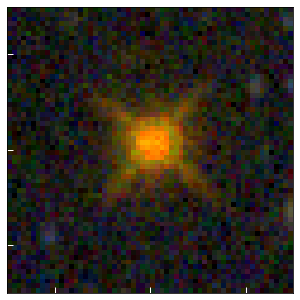

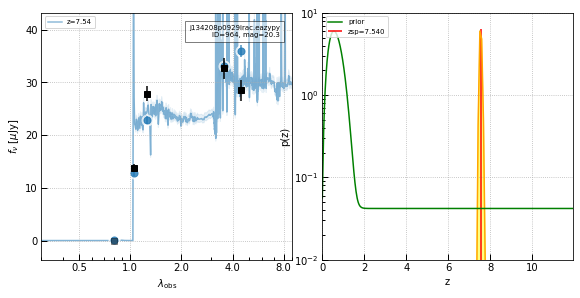

In [80]:
# z=7.65 quasar
_ = show_results(964, cutout_size=3)

### Additional candidates

Two more candidates with photometric redshifts similar to the redshift of the quasar.

 id   x      y        ra       dec    mag_auto
                     deg       deg      uJy   
--- ------ ------ ---------- -------- --------
435 2409.8 1266.1 205.523054 9.462851     25.2
PATH: ./, files:['./j134208p0929-f814w_drc_sci.fits', './j134208p0929-f105w_drz_sci.fits', './j134208p0929-f125w_drz_sci.fits']
 id    x      y        ra       dec    mag_auto
                      deg       deg      uJy   
---- ------ ------ ---------- -------- --------
1361 1683.8 2067.7 205.543500 9.485118     26.1
PATH: ./, files:['./j134208p0929-f814w_drc_sci.fits', './j134208p0929-f105w_drz_sci.fits', './j134208p0929-f125w_drz_sci.fits']


(slice(1653, 1713, None),
 slice(2037, 2097, None),
 ('f125w', 'f105w', 'f814w'),
 <Figure size 288x288 with 1 Axes>)

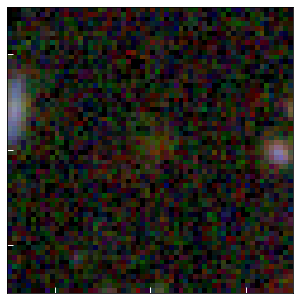

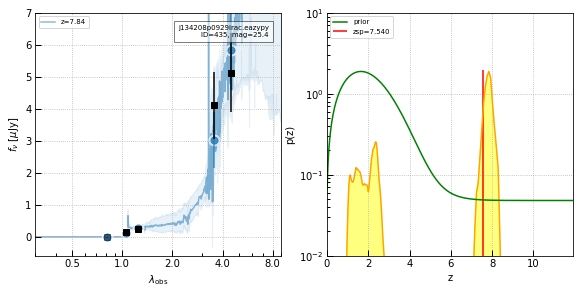

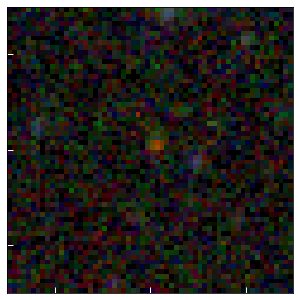

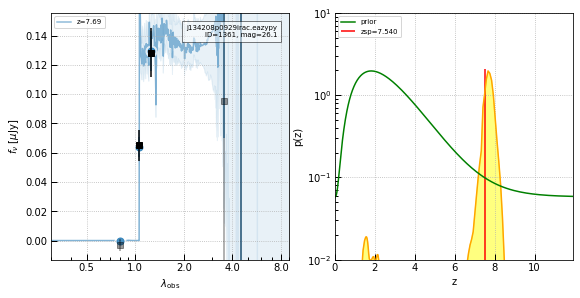

In [81]:
# Quite red in HST - IRAC.  Possible z~2
show_results(435, cutout_size=3)

# Solid candidate
show_results(1361, cutout_size=3)

## ALMA coverage

The quasar was recently observed in ALMA with many spectroscopic tunings in Bands 3-8 for an emission line survey ([Novak et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019ApJ...881...63N/abstract)).

The ALMA data are available with the following 
[ALMA Archive query](http://almascience.nrao.edu/aq/?ra_dec=205.53346%099.47583&result_view=observation&science_observations=on#sortCol=Release%20date&sortDir=asc&col_1=_checkbox_selector;;;&col_2=Project%20code;;;&col_3=Source%20name;;;&col_4=RA;;;&col_5=Dec;;;&col_6=Band;;;&col_7=Integration;;;&col_8=Release%20date;;;&col_9=Velocity%20resolution;;;km/s&col_10=Frequency%20support;;;&col_11=Pub;;;).

In [82]:
# Read ALMA and IRAC images
alma_img = 'alma_band6.fits'
if not os.path.exists(alma_img):
    os.system('wget -O {0} "https://almascience.nrao.edu/dataPortal/requests/anonymous/1650943386147/ALMA/member.uid___A001_X1296_X976.Pisco_sci.spw25.mfs.I.pbcor.fits/member.uid___A001_X1296_X976.Pisco_sci.spw25.mfs.I.pbcor.fits"'.format(alma_img))

alma = pyfits.open(alma_img)
alma_wcs = pywcs.WCS(alma[0].header)
alma_pscale = alma_wcs.wcs.cdelt[0]*3600
alma_Jybeam = np.squeeze(alma[0].data)

hst_j = pyfits.open('{0}-f125w_drz_sci.fits'.format(root))
hst_sh = hst_j[0].data.shape
hst_wcs = pywcs.WCS(hst_j[0].header)
hst_pscale = 0.1

ch1 = pyfits.open('{0}-ch1_drz_sci.fits'.format(root))[0]
ch1_model = pyfits.open('{0}-ch1_model.fits'.format(root))[0]
ch1_wcs = pywcs.WCS(ch1.header)
ch1_pscale = 0.5

ch2 = pyfits.open('{0}-ch2_drz_sci.fits'.format(root))[0]
ch2_model = pyfits.open('{0}-ch2_model.fits'.format(root))[0]

def show_cutouts(rd, cutout_size=6):
    """
    Make cutout figures
    """
    xy = np.cast[int](hst_wcs.all_world2pix(np.array([rd]), 0)).flatten()
    _ = show_results(None, xy=xy, output_size=4, cutout_size=cutout_size)
    plt.close()
    
    png = plt.imread('{0}.field.png'.format(root))
    
    ch1_xy = np.cast[int](ch1_wcs.all_world2pix(np.array([rd]), 0)).flatten()
    alma_xy = np.cast[int](alma_wcs.all_world2pix(np.array([rd+(0,0)]), 0)).flatten()

    fig = plt.figure(figsize=(12,8))

    ax = fig.add_subplot(231)
    ax.imshow(png)

    ax = fig.add_subplot(232)
    ax.imshow(ch1.data, vmin=-0.01, vmax=0.2, cmap='magma_r')
    ax.set_xlim(ch1_xy[0] + np.array([-0.5, 0.5])*cutout_size/ch1_pscale)
    ax.set_ylim(ch1_xy[1] + np.array([-0.5, 0.5])*cutout_size/ch1_pscale)

    ax = fig.add_subplot(235)
    ax.imshow(ch1.data - ch1_model.data, vmin=-0.01, vmax=0.2, 
              cmap='magma_r')
    ax.set_xlim(ch1_xy[0] + np.array([-0.5, 0.5])*cutout_size/ch1_pscale)
    ax.set_ylim(ch1_xy[1] + np.array([-0.5, 0.5])*cutout_size/ch1_pscale)

    ax = fig.add_subplot(233)
    ax.imshow(ch2.data, vmin=-0.01, vmax=0.2, cmap='magma_r')
    ax.set_xlim(ch1_xy[0] + np.array([-0.5, 0.5])*cutout_size/ch1_pscale)
    ax.set_ylim(ch1_xy[1] + np.array([-0.5, 0.5])*cutout_size/ch1_pscale)

    ax = fig.add_subplot(236)
    ax.imshow(ch2.data - ch2_model.data, vmin=-0.01, vmax=0.2, 
              cmap='magma_r')
    ax.set_xlim(ch1_xy[0] + np.array([-0.5, 0.5])*cutout_size/ch1_pscale)
    ax.set_ylim(ch1_xy[1] + np.array([-0.5, 0.5])*cutout_size/ch1_pscale)

    ax = fig.add_subplot(234)
    ax.imshow(alma_Jybeam*1000, vmin=-0.01, vmax=0.2, cmap='viridis_r')
    ax.set_xlim(alma_xy[0] + np.array([-0.5, 0.5])*cutout_size/alma_pscale)
    ax.set_ylim(alma_xy[1] + np.array([-0.5, 0.5])*cutout_size/alma_pscale)
    
    for ax in fig.axes:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    
    fig.tight_layout()

### IRAC image modeling

Here's a quick demonstration of the IRAC image modeling, which was used for the photometry shown in the SEDs above.

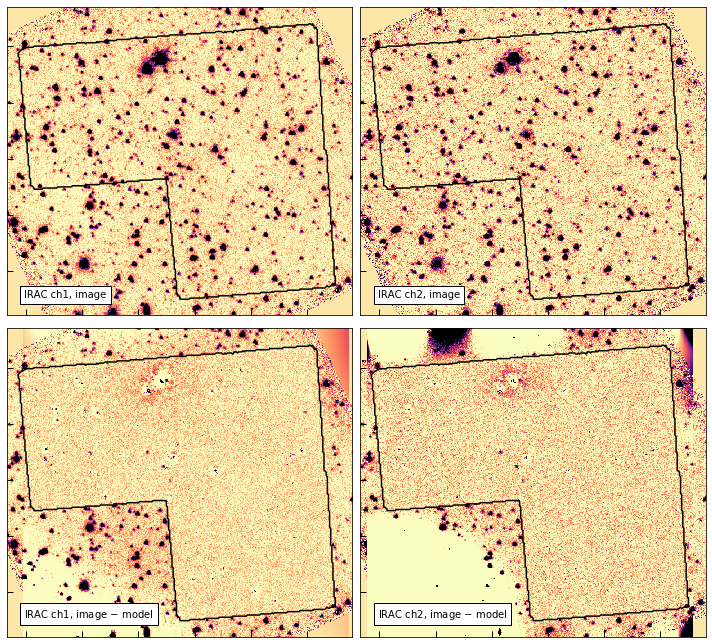

In [83]:
def get_pixel_boundaries(mask, skip=10):
    """
    Return boundary of non-zero pixels in an image
    """
    import scipy.ndimage as nd
    from skimage.measure import find_contours
    
    if not hasattr(mask, 'ndim'):
        None
    
    seg = (mask != 0)
    segmentation = nd.binary_fill_holes(mask)
    edge = find_contours(segmentation[skip//2::skip,skip//2::skip].T, level=0.8)
    shapes = [e.shape[0] for e in edge]
    return edge[np.argmax(shapes)]*skip

hst_edge = get_pixel_boundaries(hst_j[0].data != 0)
if hst_edge is not None:
    hst_edge_xy = ch1_wcs.all_world2pix(hst_wcs.all_pix2world(hst_edge, 0), 0)
else:
    hst_edge_xy = None
    
def show_irac_models(px=100):
    # Show IRAC images and model
    fig = plt.figure(figsize=[10,10*hst_sh[0]/hst_sh[1]])

    ax = fig.add_subplot(221)
    ax.imshow(ch1.data, vmin=-0.01, vmax=0.2, cmap='magma_r')
    ax.text(0.05, 0.05, 'IRAC ch1, image', ha='left', va='bottom', 
            transform=ax.transAxes, bbox={'fc':'w'})

    ax = fig.add_subplot(223)
    ax.imshow(ch1.data - ch1_model.data, vmin=-0.01, vmax=0.2, cmap='magma_r')
    ax.text(0.05, 0.05, r'IRAC ch1, image $-$ model', ha='left', va='bottom', 
            transform=ax.transAxes, bbox={'fc':'w'})

    ax = fig.add_subplot(222)
    ax.imshow(ch2.data, vmin=-0.01, vmax=0.2, cmap='magma_r')
    ax.text(0.05, 0.05, 'IRAC ch2, image', ha='left', va='bottom', 
            transform=ax.transAxes, bbox={'fc':'w'})

    ax = fig.add_subplot(224)
    ax.imshow(ch2.data - ch2_model.data, vmin=-0.01, vmax=0.2, cmap='magma_r')
    ax.text(0.05, 0.05, r'IRAC ch2, image $-$ model', ha='left', va='bottom', 
            transform=ax.transAxes, bbox={'fc':'w'})
    
    py = px*hst_sh[0]/hst_sh[1]
    
    # The IRAC image is only modeled within HST footprint
    corners = ch1_wcs.all_world2pix(hst_wcs.calc_footprint(), 0)

    for ax in fig.axes:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xlim(corners.T[0].min()+px, corners.T[0].max()-py)
        ax.set_ylim(corners.T[1].min()+py, corners.T[1].max()-py)
        if hst_edge is not None:
            ax.plot(hst_edge_xy[:,0], hst_edge_xy[:,1], color='k')

    fig.tight_layout()

show_irac_models()

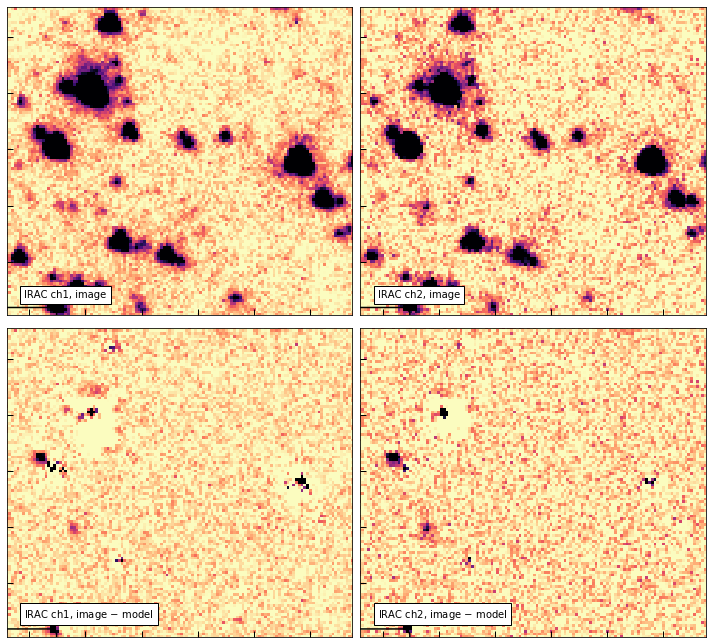

In [84]:
# Zoom in
show_irac_models()
f = 0.1
for ax in plt.gcf().axes:
    dx = ax.get_xlim()
    ax.set_xlim(np.mean(dx)+20 + f*(dx[1]-dx[0])*np.array([-1,1]))
    dy = ax.get_ylim()
    ax.set_ylim(np.mean(dy)+20 + f*(dy[1]-dy[0])*np.array([-1,1]))

## ALMA sources

There is not one (the quasar) but are rather two sources visible in the ALMA map!

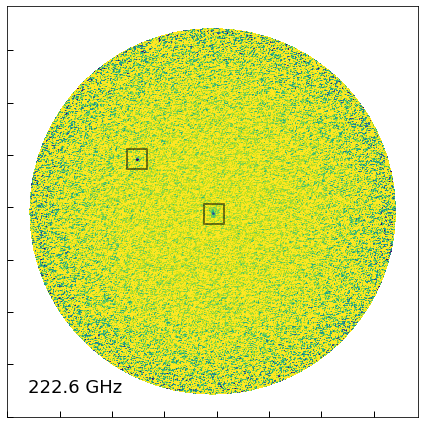

In [85]:
# Galaxy
rg, dg = 205.5360413, 9.478936196

# Quasar
rq, dq = 205.5337405, 9.477319032

# ALMA image
fig = plt.figure(figsize=[6,6])
ax = fig.add_subplot(111)
ax.imshow(alma_Jybeam*1000, vmin=-0.01, vmax=0.2, cmap='viridis_r')
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.text(0.05, 0.05, '{0:.1f} GHz'.format(alma[0].header['CRVAL3']/1.e9),
        ha='left', va='bottom', transform=ax.transAxes, fontsize=18)

for coo in [(rg, dg), (rq, dq)]:
    xy = alma_wcs.all_world2pix(np.array([coo+(0,0)]), 0).flatten()
    ax.scatter(xy[0], xy[1], marker='s', edgecolor='k', alpha=0.5, 
               s=400, facecolor='None', linewidth=2)

fig.tight_layout()

PATH: ./, files:['./j134208p0929-f814w_drc_sci.fits', './j134208p0929-f105w_drz_sci.fits', './j134208p0929-f125w_drz_sci.fits']


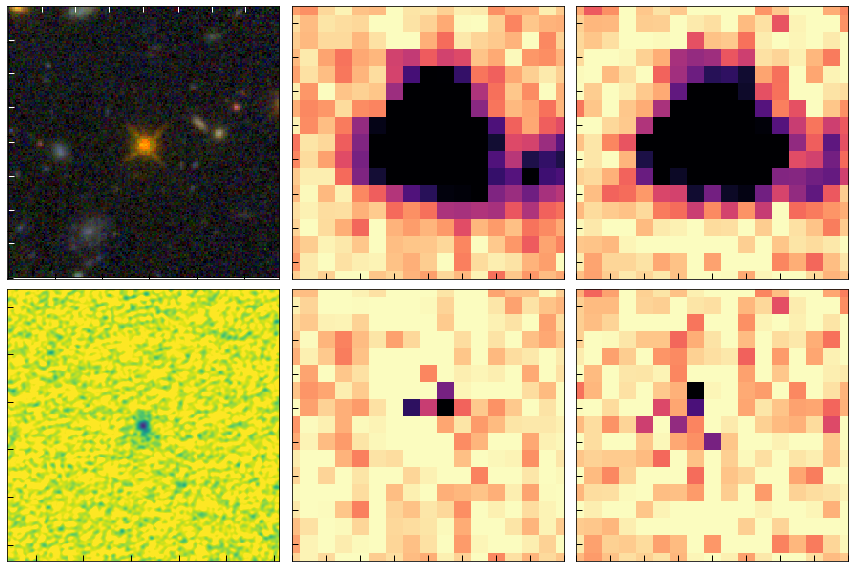

In [86]:
# Quasar
show_cutouts((rq, dq), cutout_size=8)

## Serendipitous ALMA source

The second source is all but invisible in the HST image, putting it in the class of "HST-dark" far-IR sources described frequently in the recent literature.  I really don't like that term generally as the relevant characteristic is exactly how faint a source is in the optical/NIR compared to the detection in redder bands (e.g. *Spitzer* or ALMA).  That is, whether the HST "darkness" is interesting or not depends entirely on the depth/filters of the associated HST imaging. 

PATH: ./, files:['./j134208p0929-f814w_drc_sci.fits', './j134208p0929-f105w_drz_sci.fits', './j134208p0929-f125w_drz_sci.fits']


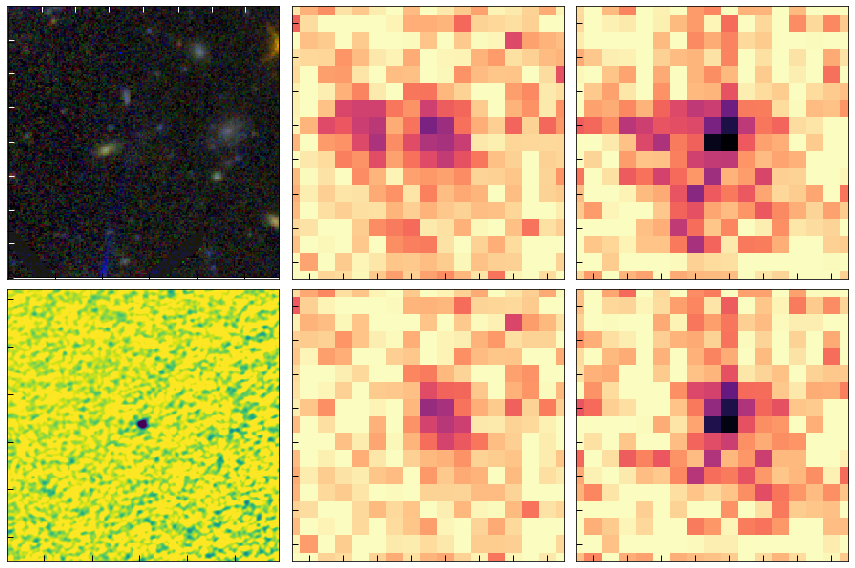

In [87]:
# "Dark" galaxy.  Not in the model so shows up in the residual
show_cutouts((rg, dg), cutout_size=8)

##  Optical-IR SED

It turns out that the serendipitous source is detected in nearly all of the available ALMA bands.  I made a quick measurement of the SED, taking the peak fluxes in the ALMA pipeline beam-corrected maps.    

The SED below shows that it is in fact a very red source.  The SED probably doesn't allow for very high redshifts (z > 4, say) since you need a fairly broad lever arm on the extinction curve in order to get  red enough between F125W and 3.6 microns and not *overproduce* the far-IR seen in the ALMA maps.

The example shown is a fiducial FSPS model at z=1.5 with V-band optical depth (~Av) = 6 (Calzetti).

So, unfortunatlely the source probably isn't at the same extreme redshift as the quasar, but that it potentially at such *low* redshift is itself somewhat surprising.  An extinction of Av=6 is higher than we generally see in deep surveys that cover thsee redshifts, but it's not crazy.  How many of these sources might be out there?

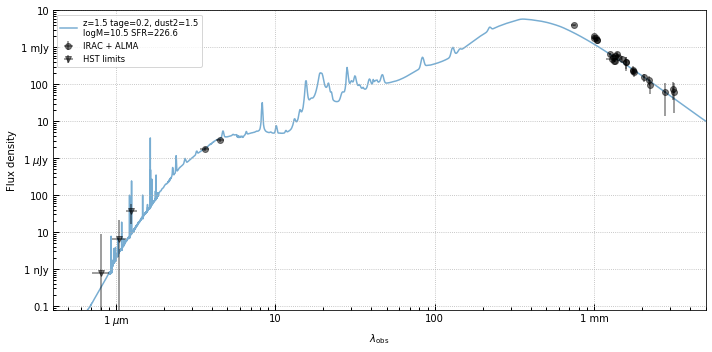

In [89]:
# Source photometry, simply the maximum pixel value in a 2.6" aperture around the target
# in All of the available ALMA bands
phot = utils.read_catalog('alma_serendip_j134208.65p092844.10.fits')

fig = plt.figure(figsize=[10,5])
ax = fig.add_subplot(111)

ax.errorbar(phot['wave'][3:], phot['fnu'][3:], 
             xerr=phot['dw'][3:], yerr=phot['efnu'][3:], 
             marker='o', alpha=0.5, linestyle='None', color='k', label='IRAC + ALMA')

# HST values are random draws from the median uncertainty in each band
ax.errorbar(phot['wave'][:3], phot['fnu'][:3], 
             xerr=phot['dw'][:3], yerr=phot['efnu'][:3], 
             marker='v', alpha=0.5, linestyle='None', color='k', label='HST limits')

ax.set_xlabel(r'$\lambda_\mathrm{obs}$')
ax.set_ylabel(r'Flux density')
ax.loglog()

ax.set_xlim(0.4, 5000)
ax.set_xticklabels([0, 0, r'1 $\mu\mathrm{m}$', '10', '100', '1 mm'])

ax.set_yticklabels([0.1, '1 nJy', 10, 100, 
                    r'1 $\mu\mathrm{Jy}$', 10, 100, '1 mJy', 10]) #r'1 $\mu\mathrm{m}$', '10', '100', '1 mm'])

ax.set_ylim(8.e-5, 1.e4)
ax.set_yticks(10**np.arange(-4, 4.1))
ax.grid()

# ad-hoc FSPS model
import fsps
import astropy.constants as const
import astropy.units as u
from astropy.cosmology import Planck15
        
try:
    # Avoid re-initializing 
    _ = sp.params['dust2']
except:
    sp = fsps.StellarPopulation(zcontinuous=True, dust_type=2, sfh=4, tau=0.1)

# guess params
dust2 = 6
z = 1.5
tage = 0.2

sp.params['dust2'] = dust2
sp.params['add_neb_emission'] = True
wsp, flux = sp.get_spectrum(tage=tage, peraa=False)

# Scale to observed frame
flux = (flux/(1+z)*const.L_sun).to(u.erg/u.s).value*1.e23*1.e6
dL = Planck15.luminosity_distance(z).to(u.cm).value
flux /= 4*np.pi*dL**2

# Normalize to 3.6um
flux_norm = np.interp(3.6e4, wsp*(1+z), flux)/phot['fnu'][3]

log_mass = np.log10(sp.stellar_mass/flux_norm)
sfr = sp.sfr_avg()/flux_norm

# Show the model
label = 'z={0:.1f} tage={1:.1f}, dust2={0:.1f}'.format(z, tage, dust2)
label += '\n'
label += 'logM={0:.1f} SFR={1:.1f}'.format(log_mass, sfr)

ax.plot(wsp*(1+z)/1.e4, flux/flux_norm, 
         alpha=0.6, zorder=-1, label=label)
ax.legend()
fig.tight_layout()